Test demo case

In [1]:
%pip install vtk

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.ndimage import zoom

from skimage.restoration import inpaint
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import ListedColormap
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt
import matplotlib.patches as mpatches
from matplotlib.path import Path
from matplotlib import ticker
from matplotlib import rcParams

import sys
import os

# Add gridder and geo_vtk modules to path using relative paths
current_dir = os.getcwd()
sys.path.insert(0, os.path.join(current_dir, 'gridder'))
sys.path.insert(0, os.path.join(current_dir, 'geo_vtk', 'src'))

from gridder import Geo_Gridder
from vtkclass import VtkClass

# This notebook is prepared for upload to GitHub.
# All dependencies are imported above.
# Please ensure that any local paths (e.g., sys.path.insert) are updated or documented for portability.
# Data files required for execution (e.g., .npy, .gpkg, .txt) should be included or referenced in the repository's README.
# For reproducibility, consider adding requirements.txt or environment.yml with all necessary packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:

def distance(x, y, x0, y0):
    """
    Return distance between point
    P[x0,y0] and a curve (x,y)
    """
    d_x = x - x0
    d_y = y - y0
    dis = np.sqrt( d_x**2 + d_y**2 )
    return dis

def min_distance(x, y, x0, y0,precision=5):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0] and a curve (x,y)
    rounded at `precision`.
    
    ARGS:
        x, y      (array)
        P         (tuple)
        precision (int)
        
    Returns min indexes and distances array.
    """
    # compute distance
    d = distance(x, y,x0, y0)
    d = np.round(d, precision)
    # find the minima
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d





def onclick(event):
   print([event.xdata, event.ydata])

def arclength(x, y, a, b):
    """
    Computes the arclength of the given curve
    defined by (x0, y0), (x1, y1) ... (xn, yn)
    over the provided bounds, `a` and `b`.

    Parameters
    ----------
    x: numpy.ndarray
        The array of x values

    y: numpy.ndarray
        The array of y values corresponding to each value of x

    a: int
        The lower limit to integrate from

    b: int
        The upper limit to integrate to

    Returns
    -------
    numpy.float64
        The arclength of the curve

    """
    bounds = (x >= a) & (x <= b)
    # print(bounds)
    return np.trapz((
        np.sqrt(
            1 + np.gradient(y[bounds], x[bounds])
        ) ** 2),
        x[bounds]
    )

In [3]:
map=np.array([[200,200,200], #anthropogenic
		[157,78,64], #peat
		[0,146,0], #clay
		[194,207,92], #silty clay
		[255,255,255], # nothing
		[255,255,0], # fine
		[243,225,6], # medium
		[231,195,22], #coarse
		[216,163,32], #gravel
		[95,95,255]]) # shells
map=map/255
my_map=ListedColormap(map,name='IMOD')

# Define labels globally so they are accessible from all functions
labels = np.array([
	'anthropogenic',
	'peat',
	'clay',
	'silty clay',
	'nothing',
	'fine sand',
	'medium sand',
	'coarse sand',
	'gravel',
	'shells'
])

In [4]:
def plot_model_with_validation_real(real, basis, del1, X, Y, tt, del_perc=None, cmap='viridis', random_indices=None,filename='model_with_validation.pdf'):

    # Prepare polygon mask for topography
    polygon = tt.T
    points = np.c_[X.ravel(), Y.ravel()]
    poly_path = Path(polygon)
    inside = poly_path.contains_points(points)
    inside_mask = inside.reshape(X.shape)
    del1_plot = del1.copy()
    del1_plot[~inside_mask] = np.nan
    if del_perc is not None:
        del_perc = del_perc.copy()
        del_perc[~inside_mask] = np.nan

    unique_values = np.unique(basis.ravel()[~np.isnan(basis.ravel())])

    # Validation/confusion matrix
    if random_indices is None:
        random_indices = np.arange(real.shape[1])
    test_data = real[:, random_indices].ravel()
    test_data_plot = np.nan * np.ones_like(real)
    pred_data_plot = np.nan * np.ones_like(real)
    test_data_plot[:, random_indices] = real[:, random_indices]
    pred_data_plot[:, random_indices] = del1_plot[:, random_indices]
    pred_data = del1[:, random_indices].ravel()
    i_keep = np.where(np.isfinite(test_data))[0]

    # Set global style
    plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16})

    fig, axes = plt.subplots(4, 1, figsize=(18, 24), constrained_layout=True)

    # Calculate common x-limits (min/max) for all subplots
    x_min = np.nanmin(X)
    x_max = np.nanmax(X)

    # Plot 1: All boreholes and validation
    im1 = axes[0].pcolor(X + 25, Y - 0.125, np.round(real), cmap=cmap, vmin=0, vmax=9, edgecolors='w', linewidths=1.0, shading='auto')
    axes[0].pcolor(X + 25, Y - 0.125, np.round(test_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='k', linewidths=1.0, shading='auto')
    axes[0].set_ylabel('Elevation (m)')
    axes[0].set_title('Boreholes used for inpainting - Boreholes used for validation')
    axes[0].set_aspect('auto')
    axes[0].set_xlim(x_min, x_max)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    cmap_obj = im1.get_cmap()
    norm = im1.norm
    legend_handles = []
    for idx, value in enumerate(unique_values):
        color = cmap_obj(norm(value))
        label = labels[int(value)] if int(value) < len(labels) else f'Unit {value}'
        patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(patch)
    axes[0].legend(handles=legend_handles, title="Legend", loc='upper left', bbox_to_anchor=(1.01, 1), ncol=1, frameon=True)

    # Plot 2: Validation vs Prediction
    axes[1].pcolor(X + 50, Y - 0.125, np.round(test_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='k', linewidths=1.0, shading='auto')
    axes[1].pcolor(X + 25, Y - 0.125, np.round(pred_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='r', linewidths=1.0, shading='auto')
    axes[1].set_ylabel('Elevation (m)')
    axes[1].set_title('Validation boreholes - Predicted boreholes')
    axes[1].set_aspect('auto')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    # Add legend for validation and prediction
    red_patch = mpatches.Patch(edgecolor='r', facecolor='none', linewidth=2, label='Prediction')
    black_patch = mpatches.Patch(edgecolor='k', facecolor='none', linewidth=2, label='Validation')
    axes[1].legend(handles=[red_patch, black_patch], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=True)

    # Plot 3: Reconstructed model
    axes[2].pcolor(X, Y, np.round(del1_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='w', linewidths=0.5, shading='auto')
    axes[2].set_title('Reconstructed model')
    axes[2].pcolor(X + 25, Y - 0.125, np.round(real), cmap=cmap, vmin=0, vmax=9, edgecolors='b', linewidths=0.5, shading='auto')
    axes[2].pcolor(X + 25, Y - 0.125, np.round(pred_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='r', linewidths=1.0, shading='auto')

    axes[2].set_ylabel('Elevation (m)')
    axes[2].set_aspect('auto')
    axes[2].grid(True, linestyle='--', alpha=0.5)
    # Add legend for validation and prediction
    red_patch = mpatches.Patch(edgecolor='b', facecolor='none', linewidth=2, label='Data Used')
    black_patch = mpatches.Patch(edgecolor='r', facecolor='none', linewidth=2, label='Prediction')
    axes[2].legend(handles=[red_patch, black_patch], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=True)


    # Plot 4: Uncertainty
    im2 = axes[3].pcolor(X, Y, del_perc, cmap='gist_gray', vmin=0, vmax=100, shading='auto')
    axes[3].set_title('% Uncertainty')
    axes[3].set_ylabel('Elevation (m)')
    axes[3].set_xlabel('Distance (m)')
    axes[3].set_aspect('auto')
    axes[3].grid(True, linestyle='--', alpha=0.5)
    cbar = fig.colorbar(im2, ax=axes[3], orientation='vertical', pad=0.02, fraction=0.04)
    cbar.set_label('% Error')
    cbar.ax.tick_params(labelsize=12)
    rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
    fig.savefig(filename, format="pdf", bbox_inches="tight")
    # Confusion Matrix (only classes present in true or predicted labels)
    present_true = np.unique(test_data[i_keep])
    present_pred = np.unique(pred_data[i_keep])
    present_classes = np.unique(np.concatenate([present_true, present_pred]))
    # Remove nan and zero if not present
    present_classes = present_classes[np.isfinite(present_classes)]
    # Only keep classes with at least one true or predicted sample
    mask_present = np.isin(test_data[i_keep], present_classes) | np.isin(pred_data[i_keep], present_classes)
    # Get corresponding labels
    present_labels = [labels[int(c)] if int(c) < len(labels) else f'Unit {c}' for c in present_classes]
    fig_cm, ax_cm = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
    confusion_matrix = metrics.confusion_matrix(
        test_data[i_keep][mask_present], 
        pred_data[i_keep][mask_present], 
        labels=present_classes
    )
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax_cm, cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    ax_cm.set_title('Confusion Matrix (Present Classes)', fontsize=18)
    ax_cm.set_xticks(np.arange(len(present_labels)))
    ax_cm.set_yticks(np.arange(len(present_labels)))
    ax_cm.set_xticklabels(present_labels, rotation=45, ha='right', fontsize=14)
    ax_cm.set_yticklabels(present_labels, fontsize=14)
    ax_cm.grid(False)
    fig_cm.savefig(filename[:-4]+'_validation.pdf', format="pdf", bbox_inches="tight")
    plt.show()


In [5]:
def plot_model_with_validation(real, basis, del1, del_perc=None, cmap='viridis', random_indices=None):
    fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
    del1 = del1.copy()
    del1[np.isnan(real)] = np.nan

    # First subplot
    im1 = axes[0][0].imshow(basis, cmap=cmap, vmin=0, vmax=9)
    axes[0][0].set_ylabel('Depth (cm)')
    axes[0][0].set_title('All boreholes')
    axes[0][0].set_xlim(-0.5-2, basis.shape[1] - 0.5 + 2)

    # Second subplot
    if del_perc is None:
        uncertainty = 1 - np.abs(del1 - 0.5) * 2
        uncertainty_percent = uncertainty * 100
    else:
        uncertainty_percent = del_perc

    im2 = axes[0][1].imshow(uncertainty_percent, cmap='gist_gray', vmin=0, vmax=100)
    axes[0][1].set_title('% Uncertainty')
    axes[0][1].set_xlabel('Distance (m)')
    axes[0][1].set_xlim(-0.5-2, basis.shape[1] - 0.5 + 2)
    cbar = fig.colorbar(im2, ax=axes[0][1], orientation='vertical', pad=0.02, fraction=0.046)
    cbar.set_label('% Error')

    # Third subplot
    axes[0][2].imshow(np.round(del1), cmap=cmap, vmin=0, vmax=9)
    axes[0][2].set_title('Reconstructed model')
    unique_values = np.unique(basis.ravel()[~np.isnan(basis.ravel())])

    cmap_obj = im1.get_cmap()
    norm = im1.norm
    legend_handles = []
    for idx, value in enumerate(unique_values):
        color = cmap_obj(norm(value))
        if int(value) < len(labels):
            label = labels[int(value)]
        else:
            label = f'Unit {value}'
        patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(patch)

    axes[0][0].legend(handles=legend_handles, title="Legend",
                      loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1, frameon=True)

    # Fourth subplot
    axes[1][0].imshow(np.round(real), cmap=cmap, vmin=0, vmax=9)
    axes[1][0].set_title('Real model')

    # Validation/confusion matrix
    if random_indices is None:
        random_indices = np.arange(real.shape[1])
    test_data = real[:, random_indices].ravel()
    pred_data = del1[:, random_indices].ravel()
    i_keep = np.where(np.isfinite(test_data))[0]
    confusion_matrix = metrics.confusion_matrix(test_data[i_keep], pred_data[i_keep])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=axes[1][1], cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    axes[1][1].set_title('Confusion Matrix')

    tick_labels = [h.get_label() for h in legend_handles]
    axes[1][1].set_xticks(np.arange(len(tick_labels)))
    axes[1][1].set_yticks(np.arange(len(tick_labels)))
    axes[1][1].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1][1].set_yticklabels(tick_labels)

    # Hide unused subplot
    axes[1][2].axis('off')
    diff_binary = (np.round(real) != np.round(del1)).astype(int)
    axes[1][2].imshow(diff_binary, cmap='gray', vmin=0, vmax=1)
    axes[1][2].set_title('Binary Difference Mask')

    #plt.tight_layout()
    plt.show()


In [6]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - labels: list of class names
    - title: title of the plot
    - cmap: colormap for the matrix
    """
    fig_cm, ax_cm = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax_cm, cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    ax_cm.set_title('Confusion Matrix', fontsize=18)
    ax_cm.set_xticks(np.arange(len(labels)))
    ax_cm.set_yticks(np.arange(len(labels)))
    ax_cm.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
    ax_cm.set_yticklabels(labels, fontsize=14)
    ax_cm.grid(False)
    plt.show()
    rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
    fig_cm.savefig("confusion_matrix.pdf", format="pdf", bbox_inches="tight")

For the first part of the code, we do not need to grid the data. It's already gridded.
Let's chose the number of pixels on x and y direction

In [7]:
nx = 20
ny = 60


Example 1. 

Let's make horizontal layering

In [8]:
basis=np.nan*np.zeros((nx, ny))

basis[0:np.int32(nx/2),0]=2
basis[np.int32(nx/2):,0]=5

basis[0:np.int32(nx/2),-1]=2
basis[np.int32(nx/2):,-1]=5


As mentioned above, we call directy the one_vs_all function and we do not grid. Thus, the input need is a 2d numpy array, where we have information along some pixels, and the rest is nan. This is the area that we will generate a model

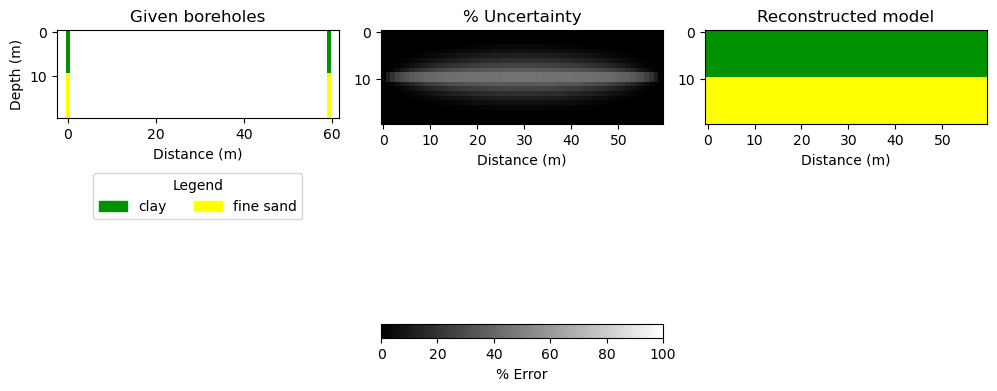

In [9]:

int1 = Geo_Gridder(None, None)
int1.one_vs_all(image=basis, x_weight=1.0, y_weight=3.0)



int1.plot_model(cmap=my_map,filename='model1.pdf',labels=labels)



Let's make smooth dipping

In [10]:
basis=np.nan*np.zeros((nx, ny))

basis[0:np.int32(nx/2),0]=2
basis[np.int32(nx/2):,0]=5

basis[0:np.int32(nx/2)+4,-1]=2
basis[np.int32(nx/2)+4:,-1]=5




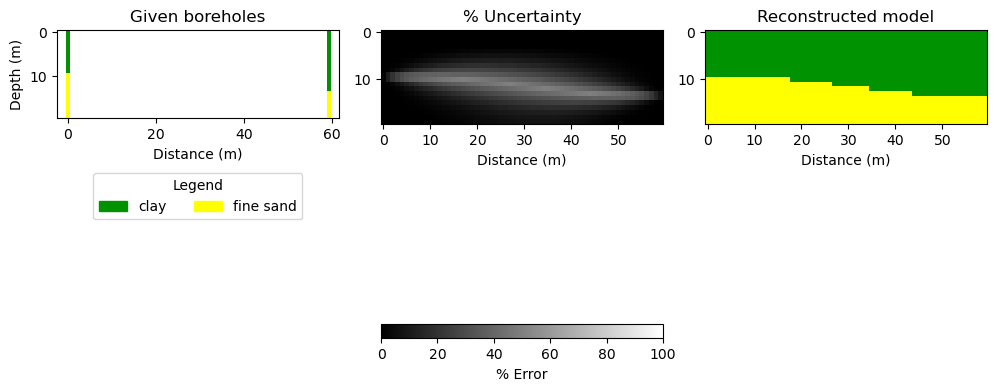

In [11]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model2.pdf',labels=labels)


Let's make a fault

In [12]:
basis=np.nan*np.zeros((nx, ny))

basis[0:3,0]=2
basis[3:,0]=5

basis[:nx-4,-1]=2
basis[nx-4:,-1]=5



Let's make layers that get thin

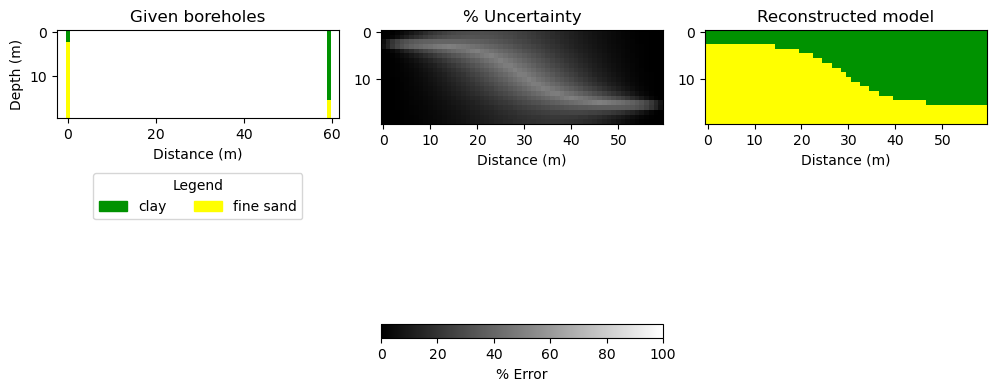

In [13]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model3.pdf',labels=labels)


In [14]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:7,-1]=2
basis[7:12,-1]=5
basis[12:,-1]=2



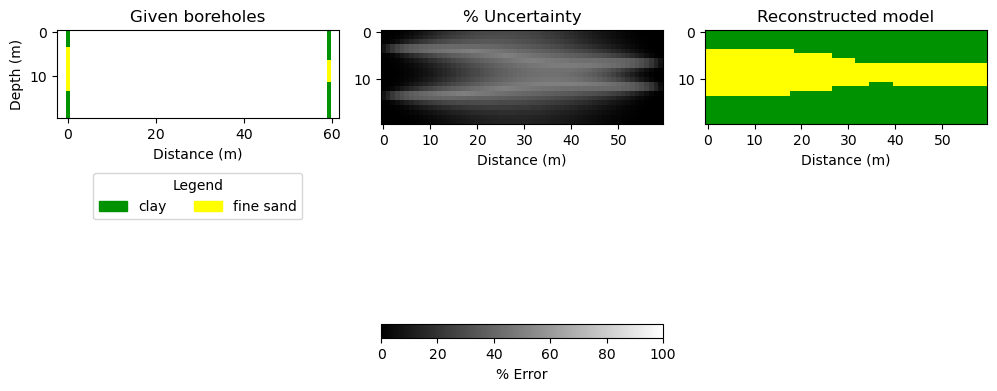

In [15]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model4.pdf',labels=labels)


In [16]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=2


4

4

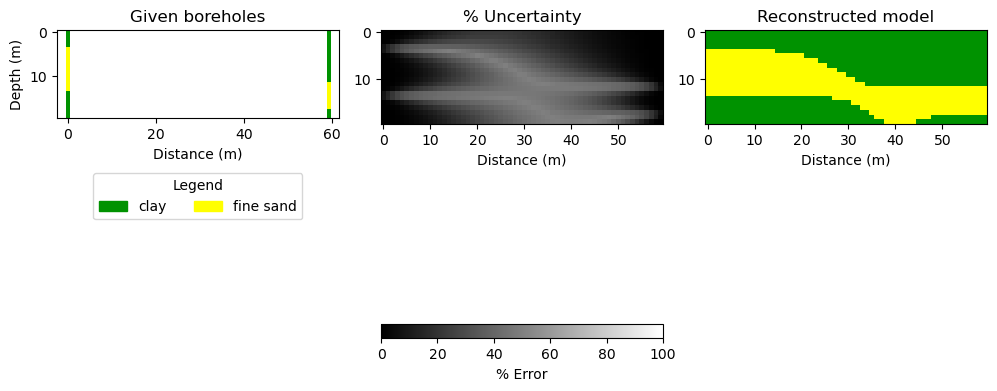

In [17]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model4a.pdf',labels=labels)


Same as above, but equal distance

In [18]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:8,-1]=2
basis[8:18,-1]=5
basis[18:,-1]=2



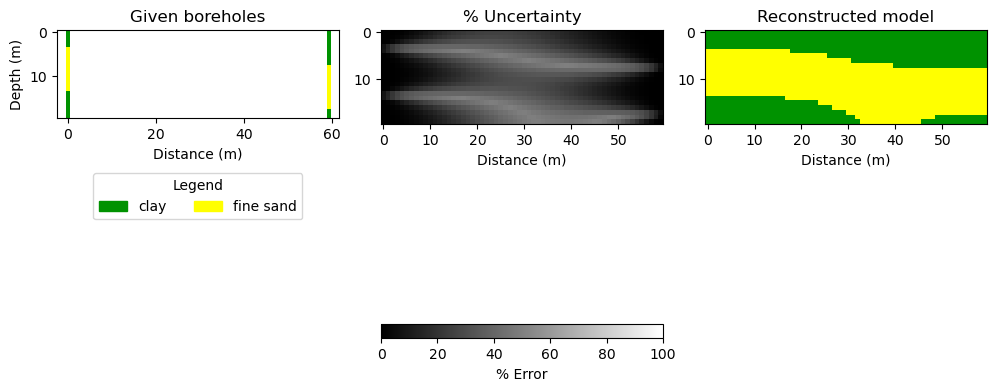

In [19]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model4b.pdf',labels=labels)


let's go to three boreholes

In [20]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:8,np.int32(nx)]=2
basis[8:18,np.int32(nx)]=5
basis[18:,np.int32(nx)]=2

basis[0:4,-1]=2
basis[4:14,-1]=5
basis[14:,-1]=2



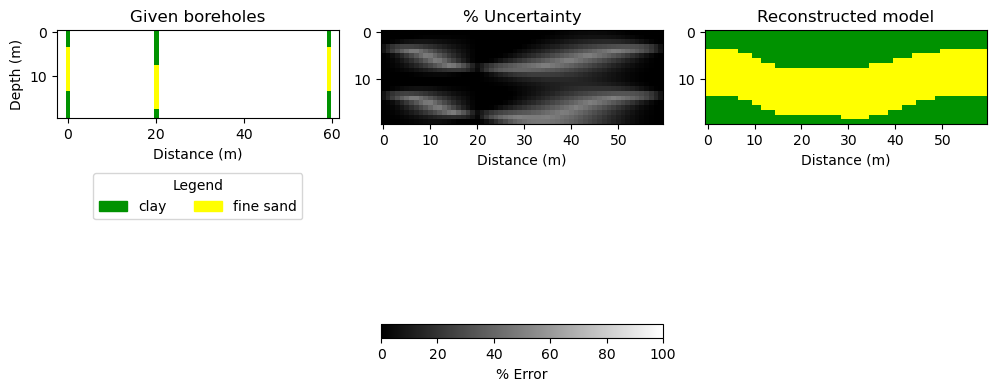

In [21]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model5.pdf',labels=labels)


Layer that get thicker and thicker

In [22]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:16,0]=5
basis[16:,0]=2


basis[0:6,np.int32(ny/2)]=2
basis[6:14,np.int32(ny/2)]=5
basis[14:,np.int32(ny/2)]=2

basis[0:7,-1]=2
basis[7:12,-1]=5
basis[12:,-1]=2



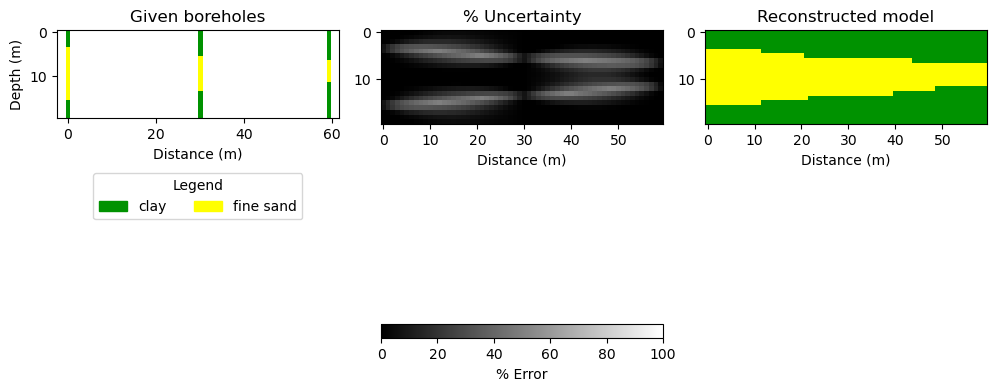

In [23]:
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model6.pdf',labels=labels)


let's try 3 layers

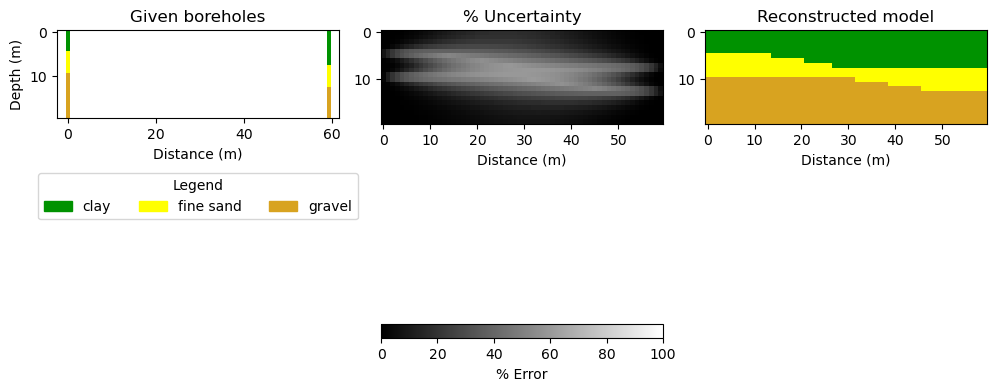

In [24]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:8,-1]=2
basis[8:13,-1]=5
basis[13:,-1]=8

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model7.pdf',labels=labels)


make a fault

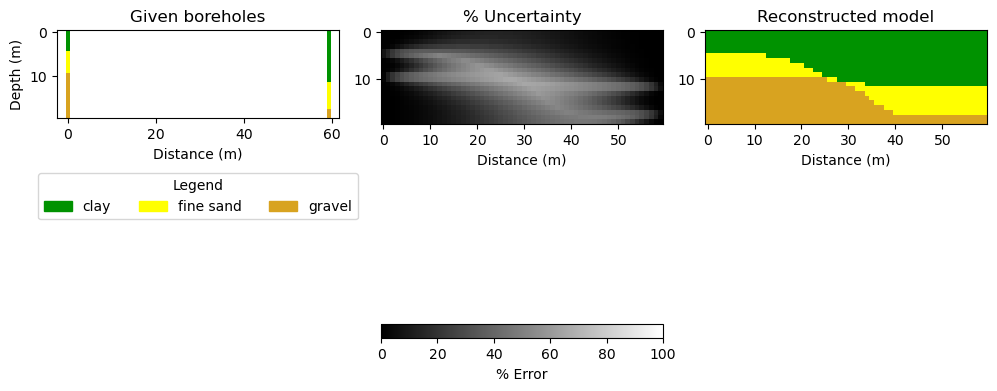

In [25]:

basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0)
int1.plot_model(cmap=my_map,filename='model8_3.pdf',labels=labels)



Make some layer discontiniuos

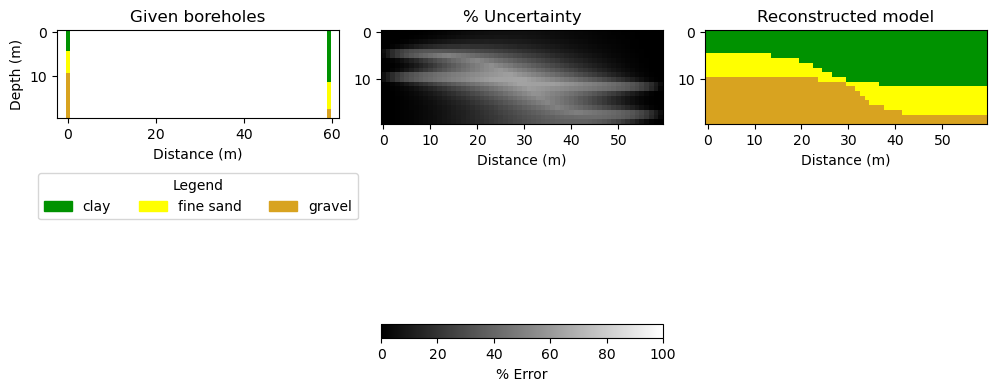

In [26]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=4.0,)
int1.plot_model(cmap=my_map,filename='model8_4.pdf',labels=labels)


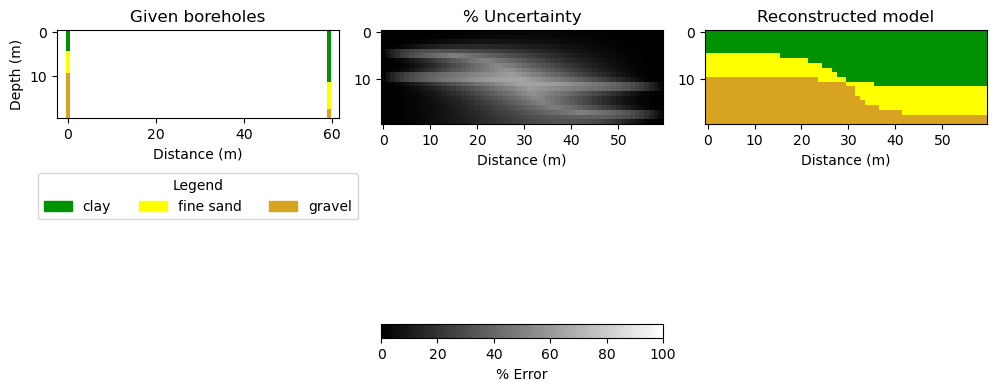

In [27]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=5.0,)
int1.plot_model(cmap=my_map,filename='model8_5.pdf',labels=labels)


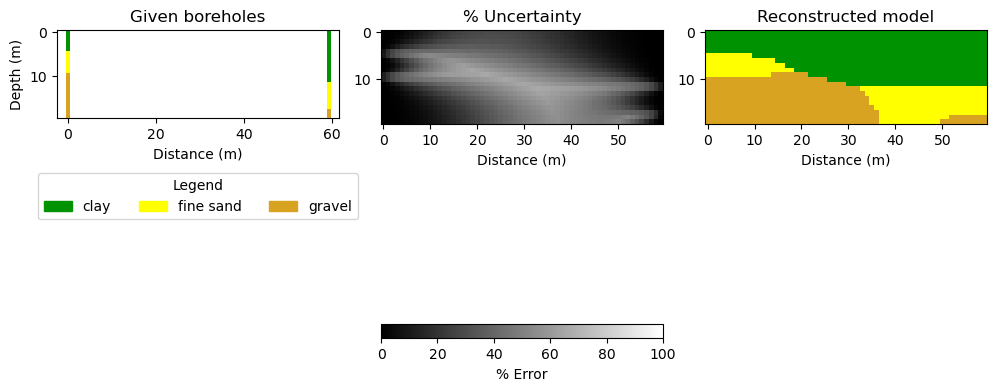

In [28]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=2.0,)
int1.plot_model(cmap=my_map,filename='model8_2.pdf',labels=labels)


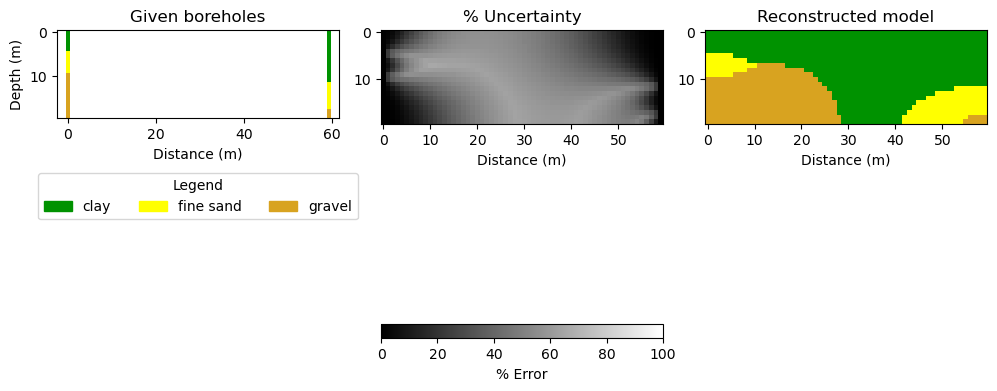

In [29]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=1.0,)
int1.plot_model(cmap=my_map,filename='model8_1.pdf',labels=labels)


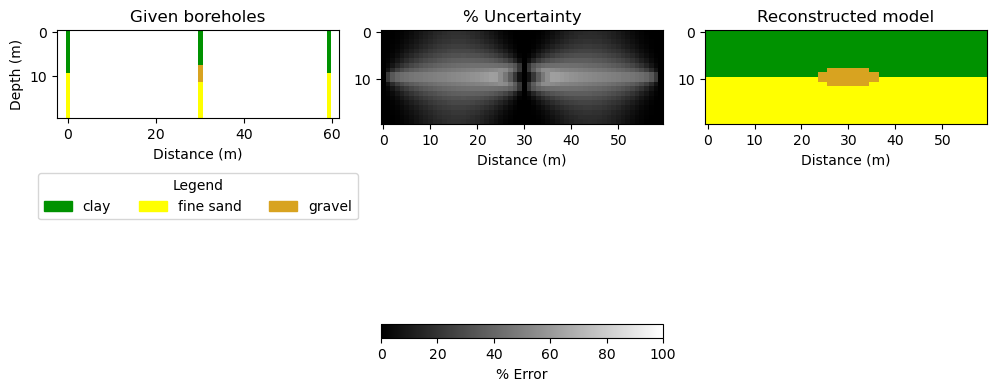

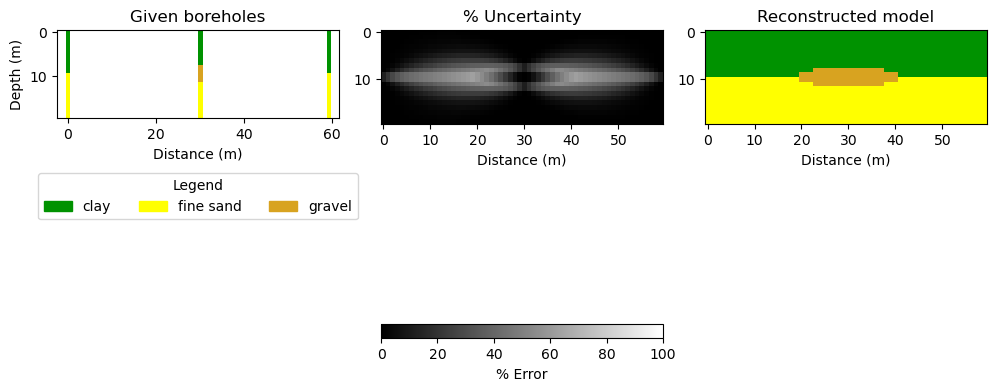

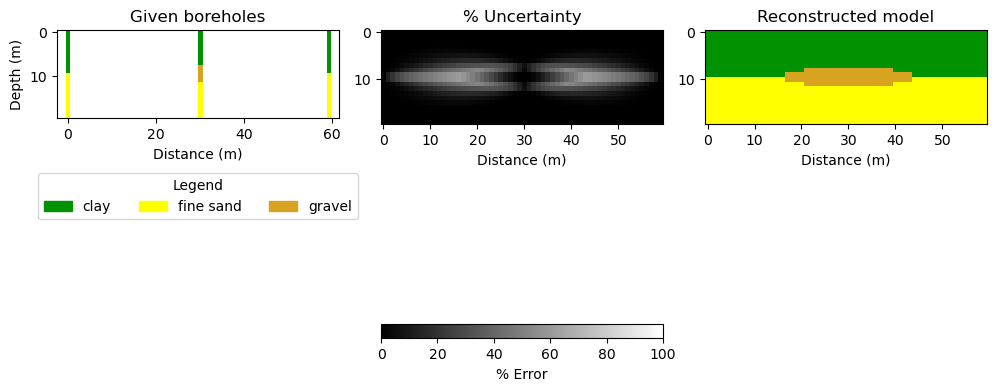

In [30]:
basis=np.nan*np.zeros((nx, ny))

basis[0:10,0]=2
basis[10:,0]=5


basis[0:10,np.int32(ny/2)]=2   
basis[12:,np.int32(ny/2)]=5
basis[8:12,np.int32(ny/2)]=8



basis[0:10,-1]=2
basis[10:,-1]=5


int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=1.0,)
int1.plot_model(cmap=my_map,filename='model9_1.pdf',labels=labels)

int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=2.0,)
int1.plot_model(cmap=my_map,filename='model9_2.pdf',labels=labels)
int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=3.0,)
int1.plot_model(cmap=my_map,filename='model9_3.pdf',labels=labels)


Here we import the VES example

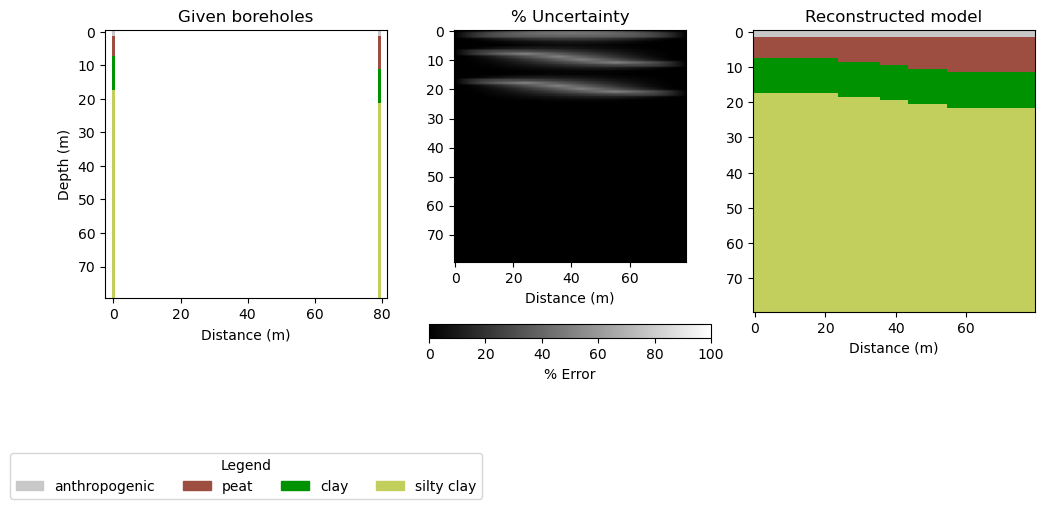

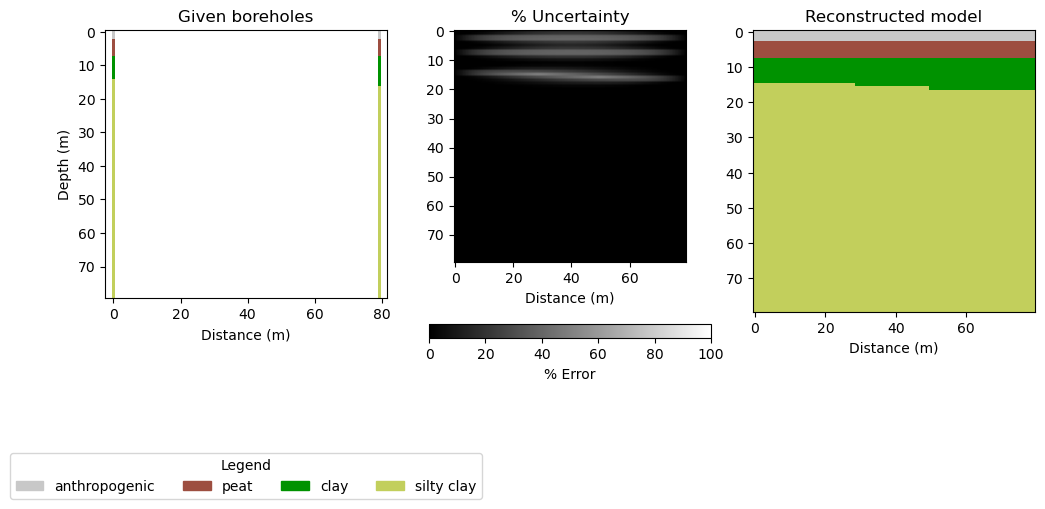

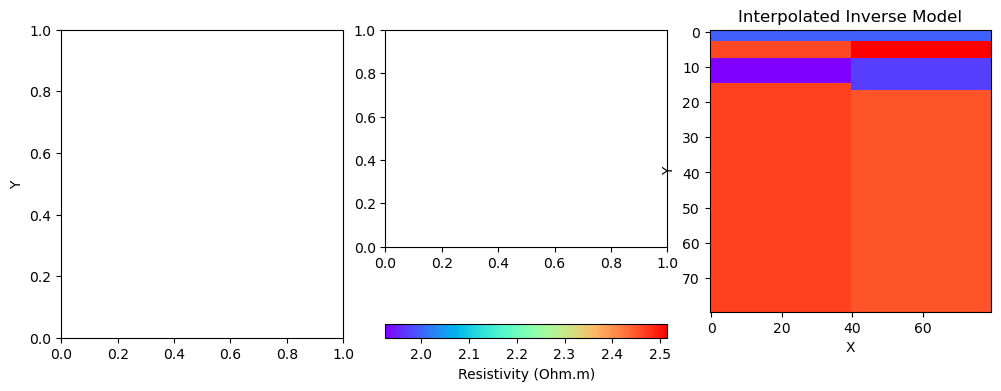

In [31]:
from scipy.interpolate import griddata

real_model = np.load('real_model.npy')
inv_model = np.load('inv_model.npy')
real_model_cat = np.load('real_model_cat.npy')
inv_model_cat = np.load('inv_model_cat.npy')



#do some resampling
real_model_cat_resampled = zoom(real_model_cat, (80 / real_model_cat.shape[0], 80 / real_model_cat.shape[1]), order=0)

int1=Geo_Gridder(None,None)
int1.one_vs_all(real_model_cat_resampled,x_weight=1.0,y_weight=10.0,)
int1.plot_model(cmap=my_map,filename='ves_real.pdf',labels=labels)


inv_model_cat_resampled = zoom(inv_model_cat, (80 / inv_model_cat.shape[0], 80 / inv_model_cat.shape[1]), order=0)

int1=Geo_Gridder(None,None)
int1.one_vs_all(inv_model_cat_resampled,x_weight=1.0,y_weight=10.0,)
int1.plot_model(cmap=my_map,filename='ves_inv.pdf',labels=labels)


# Perform 2D linear interpolation where there are NaNs in inv_model
inv_model_resampled = zoom(inv_model, (80 / inv_model.shape[0], 80 / inv_model.shape[1]), order=0)

inv_model_interp = inv_model_resampled.copy()
x = np.arange(inv_model_interp.shape[1])
y = np.arange(inv_model_interp.shape[0])
X, Y = np.meshgrid(x, y)

# Convert inv_model values to log10 before interpolation
# Mask valid points
valid_mask = np.isfinite(inv_model_interp)
inv_model_interp[valid_mask] = np.log10(inv_model_interp[valid_mask])

points = np.column_stack((X[valid_mask], Y[valid_mask]))
values = inv_model_interp[valid_mask]

# Interpolate only at NaN locations
nan_mask = ~valid_mask
inv_model_interp[nan_mask] = griddata(points,values, (X[nan_mask], Y[nan_mask]), method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=False)

contour = axes[2].imshow(inv_model_interp, cmap='rainbow')
cbar = fig.colorbar(contour, ax=axes[1], orientation='horizontal', pad=0.25, fraction=0.046)
cbar.set_label('Resistivity (Ohm.m)')
axes[2].set_title('Interpolated Inverse Model')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[0].set_ylabel('Y')

    # Align subplots on the top side
for ax in axes:
    ax.set_anchor('N')

plt.subplots_adjust(wspace=0.15)
rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
plt.savefig('interp.pdf', format='pdf', bbox_inches='tight')
plt.show()

Let's go to a 2d validation model (not showing in the paper)

In [32]:
geotop=np.load('geotop.npy')

#The model is a 3d model national model, where different elevation exists. Here we find the elevation of the model, in the selected area. We will name it demo
demo=geotop[20,:,:].T
#demo=np.flipud(demo)
top=np.zeros((demo.shape[1]))
for i in range(0,demo.shape[1]):
    ix=np.where(np.isnan(demo[:,i]))[0][0]
    top[i]=ix

demo=demo[:np.max(top).astype('int32'),:]    
demo=np.flipud(demo)



In [33]:
# Assume demo is already defined
total_samples = int(0.8 * demo.shape[1])  # Define the total number of samples

# Create a set of possible indices excluding 0 and demo.shape[1] - 1
possible_indices = list(range(1, demo.shape[1] - 1))

# Use np.random.choice to select samples without replacement
random_indices = np.random.choice(possible_indices, size=total_samples, replace=False)



In [34]:

# make a more symmetric pattern
indices = np.arange(demo.shape[1])
mask = np.ones(demo.shape[1], dtype=bool)
ii=10
mask[ii-1::ii] = False  # Remove every 5th element (0-based indexing)
random_indices = indices[mask]



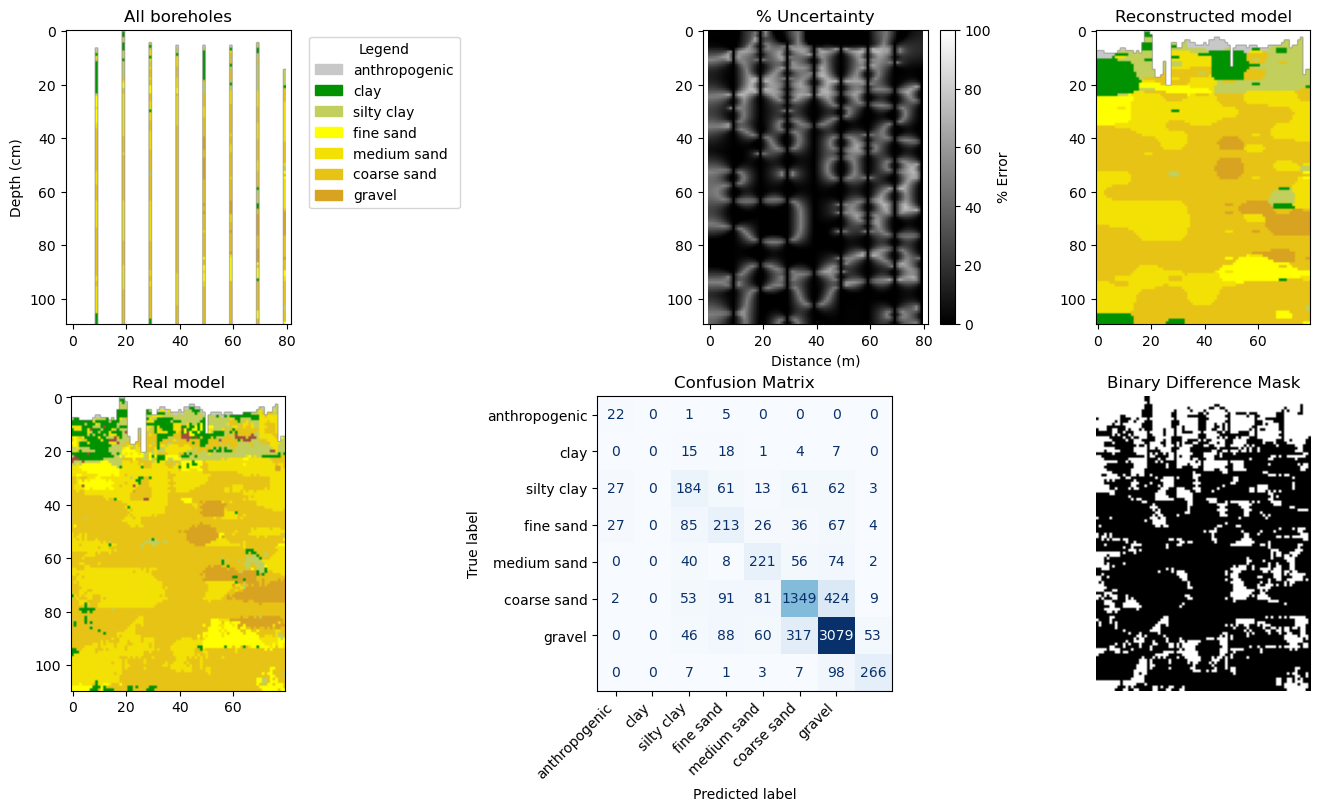

In [35]:
basis = demo.copy()

# Ensure random_indices are within valid column range
valid_indices = random_indices[random_indices < basis.shape[1]]
basis[:, valid_indices] = np.nan


int1=Geo_Gridder(None,None)
int1.one_vs_all(basis,x_weight=1.0,y_weight=1.0,)
int1.plot_model_with_validation(demo,cmap=my_map,labels=labels, random_indices=valid_indices,filename='model9_2.pdf')


Now let's go to a real model

In [36]:
import geopandas as gpd
import pandas as pd
data=gpd.read_file('top_layer.gpkg')
import shapely.geometry as geom

In [37]:
data.to_csv('test.csv')

This is the profile I will project all boreholes, to make a 2D model. It could be 3D, but that's for later. We have a lot og bereholes in the area, we will only make a 2d slice along one profile

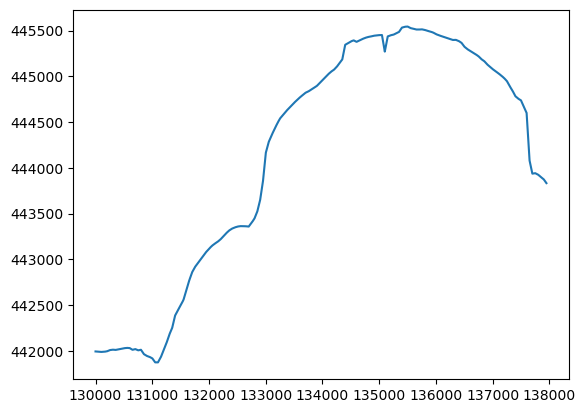

In [38]:

coor=np.loadtxt('profile2.txt')
yn=np.interp(
    np.arange(np.min(coor[:,0]),np.max(coor[:,0]),0.5), 
    
    coor[:,0], coor[:,1])
coor=np.c_[np.arange(np.min(coor[:,0]),np.max(coor[:,0]),0.5),yn]
plt.plot(coor[:,0],coor[:,1])

C:\Users\Marios\AppData\Local\Temp\ipykernel_41092\2657338756.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Dis'].iloc[i]=tt
C:\Users\Marios\AppData\Local\Temp\ipykernel_41092\2657338756.py:8: SettingWithCopyWarning: 
A value is 

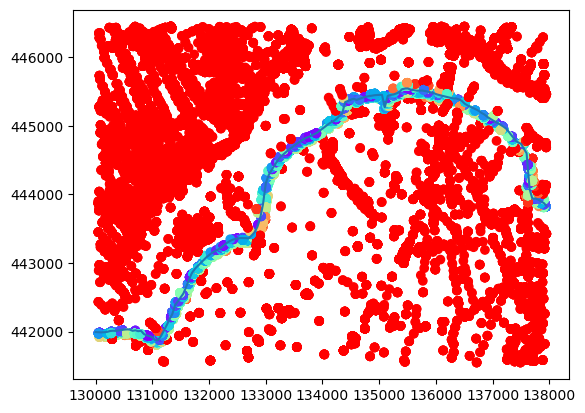

In [39]:
line = geom.LineString(coor[:,:2])

data['Dis']=1e6

for i in range(0,len(data)):
    tt,tt2=min_distance(coor[:,0], coor[:,1], data['x'].iloc[i], data['y'].iloc[i])
    tt=tt2[np.min(tt)]
    data['Dis'].iloc[i]=tt

fig, ax = plt.subplots()
ax.scatter(data['x'], data['y'], c=data['Dis'],cmap='rainbow',vmax=100)
ax.plot(coor[:,0],coor[:,1])

In [40]:
data['xx']=0
data['yy']=0

start_x=data['x'].min()
start_y=data['y'].min()
data['arc']=0

for i in range(0,len(data)):
    point=geom.Point(data['x'].iloc[i],data['y'].iloc[i])
    # print(point.distance(line))
    point_on_line = line.interpolate(line.project(point))

    data['xx'].iloc[i]=point_on_line.x
    data['yy'].iloc[i]=point_on_line.y
    
    data['arc'].iloc[i]=arclength(coor[:,0], coor[:,1], np.min(coor[:,0]), point_on_line.x)
    # ax.scatter(data['x'].iloc[i],data['y'].iloc[i])
    # ax.scatter(point_on_line.x,point_on_line.y)
    # ax.set_title('%.1f'%data_small['arc'].iloc[i])
    
    # plt.pause(1)    


C:\Users\Marios\AppData\Local\Temp\ipykernel_41092\1718466818.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['xx'].iloc[i]=point_on_line.x
C:\Users\Marios\AppData\Local\Temp\ipykernel_41092\1718466818.py:13: SettingWithCopyWarning

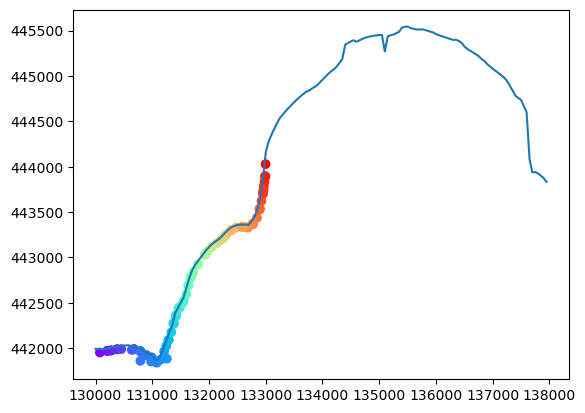

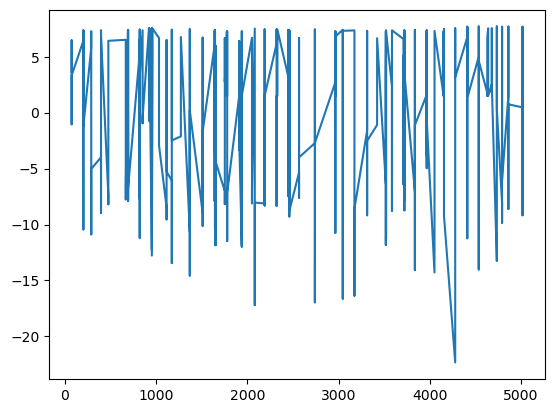

In [41]:


data_line=data[(data['Dis']<150)  & (data['x']<133000)]
data_small=data_line.drop_duplicates(['name'],keep='first')
data_small=data_small.reset_index()

    
data_line.to_excel('data_line.xlsx')
data_small.to_excel('data_small.xlsx')
data_small=data_small.reset_index()

# data_sorted=data_small.sort_values(by=['arc'])
# plt.plot(data_sorted['arc'],data_sorted['NAP_start'],'-x')


fig, ax = plt.subplots()
ax.plot(coor[:,0],coor[:,1])
del1=data_small[data_small['NAP_start']>5]
ax.scatter(del1['x'], del1['y'],c=del1['arc'],cmap='rainbow')


# finally we will keep only on top of levee


data_final=data[data['name'].isin(del1['name'])]

data_final.to_excel('data_final.xlsx')


data_final=data_final.sort_values(by=['arc'])
plt.figure()
plt.plot(data_final['arc'],data_final['NAP_start'])

#make 10ck intervales
data_final=data_final[data_final['GTP number'].notna()]



# make quick class for stuctures
# Assign an integer to each unique value in 'classification_for_vtk_number'
unique_classes = data_final['classification_for_VTK_number'].unique()
class_to_int = {cls: idx for idx, cls in enumerate(unique_classes)}
data_final['class_int'] = data_final['classification_for_VTK_number'].map(class_to_int)


for i in range(0,len(data_final)):
    depths=np.arange(data_final['NAP_start'].iloc[i],data_final['NAP_end'].iloc[i],-0.1)
    
    tmp=np.c_[data_final['arc'].iloc[i]*np.ones_like(depths),
              depths,
              data_final['GTP number'].iloc[i]*np.ones_like(depths),              
              data_final['class_int'].iloc[i]*np.ones_like(depths)
        ]
    
    if i==0:
        out=tmp
    else:
        out=np.r_[out,tmp]
    
    

In [42]:

training_points=out[:,:2]
training_data=out[:,2]
training_data2=out[:,3]

int1=Geo_Gridder(training_points, training_data,method='mode')
int1.make_grid(dx=25,dy=0.5)
int1.gridder()

int2=Geo_Gridder(training_points, training_data2,method='mode')
int2.make_grid(dx=25,dy=0.5)
int2.gridder()

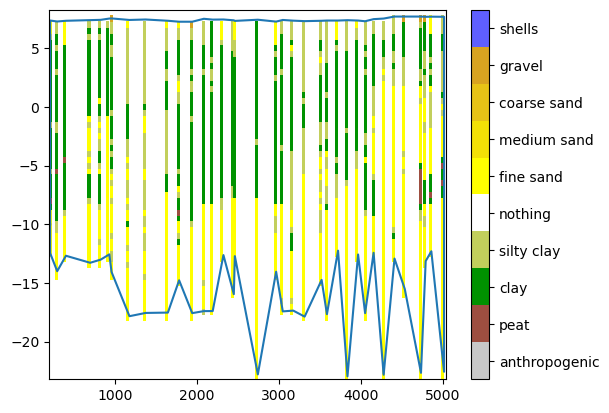

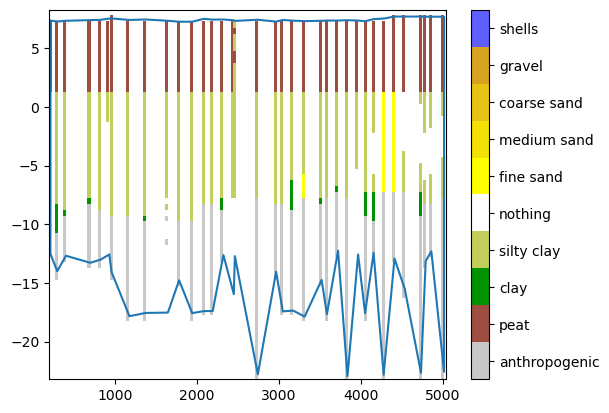

In [43]:
#interpolate top bottom
import alphashape
from descartes import PolygonPatch

alpha_shape = alphashape.alphashape(out[:,:2], 1/150)
tt=np.array(alpha_shape.exterior.xy)
fig, ax = plt.subplots()
mat=plt.pcolor(int1.xg,int1.yg,int1.bs,vmin=0-0.5,vmax=9+0.5,cmap=my_map)

cax = plt.colorbar(mat)
cax.set_ticks(ticks=np.arange(0, 9 + 1),labels=labels)
plt.plot(tt[0,:],tt[1,:])
basis=int1.bs.copy()

col_indices = np.where(np.isfinite(basis).any(axis=0))[0]
# Exclude the first and last index
valid_indices = col_indices[1:-1]

# Calculate number of samples (20% of valid_indices)
n_samples = max(1, int(0.2 * len(valid_indices)))

# Randomly select 20% of the indices
random_indices = np.random.choice(valid_indices, size=n_samples, replace=False)

valid_indices = col_indices[1:-1]
# Select every 5th index from valid_indices only (first and last NOT included)
random_indices = valid_indices[::5]
#random_indices[-1] = 168
basis_inpaint= basis.copy()
basis_inpaint[:, random_indices] = np.nan  # Set the selected indices to NaN    



fig, ax = plt.subplots()
mat2=plt.pcolor(int2.xg,int2.yg,int2.bs,vmin=0-0.5,vmax=9+0.5,cmap=my_map)

cax = plt.colorbar(mat2)
cax.set_ticks(ticks=np.arange(0, 9 + 1),labels=labels)
plt.plot(tt[0,:],tt[1,:])
basis2=int2.bs.copy()

basis_inpaint2= basis2.copy()
basis_inpaint2[:, random_indices] = np.nan  # Set the selected indices to NaN    




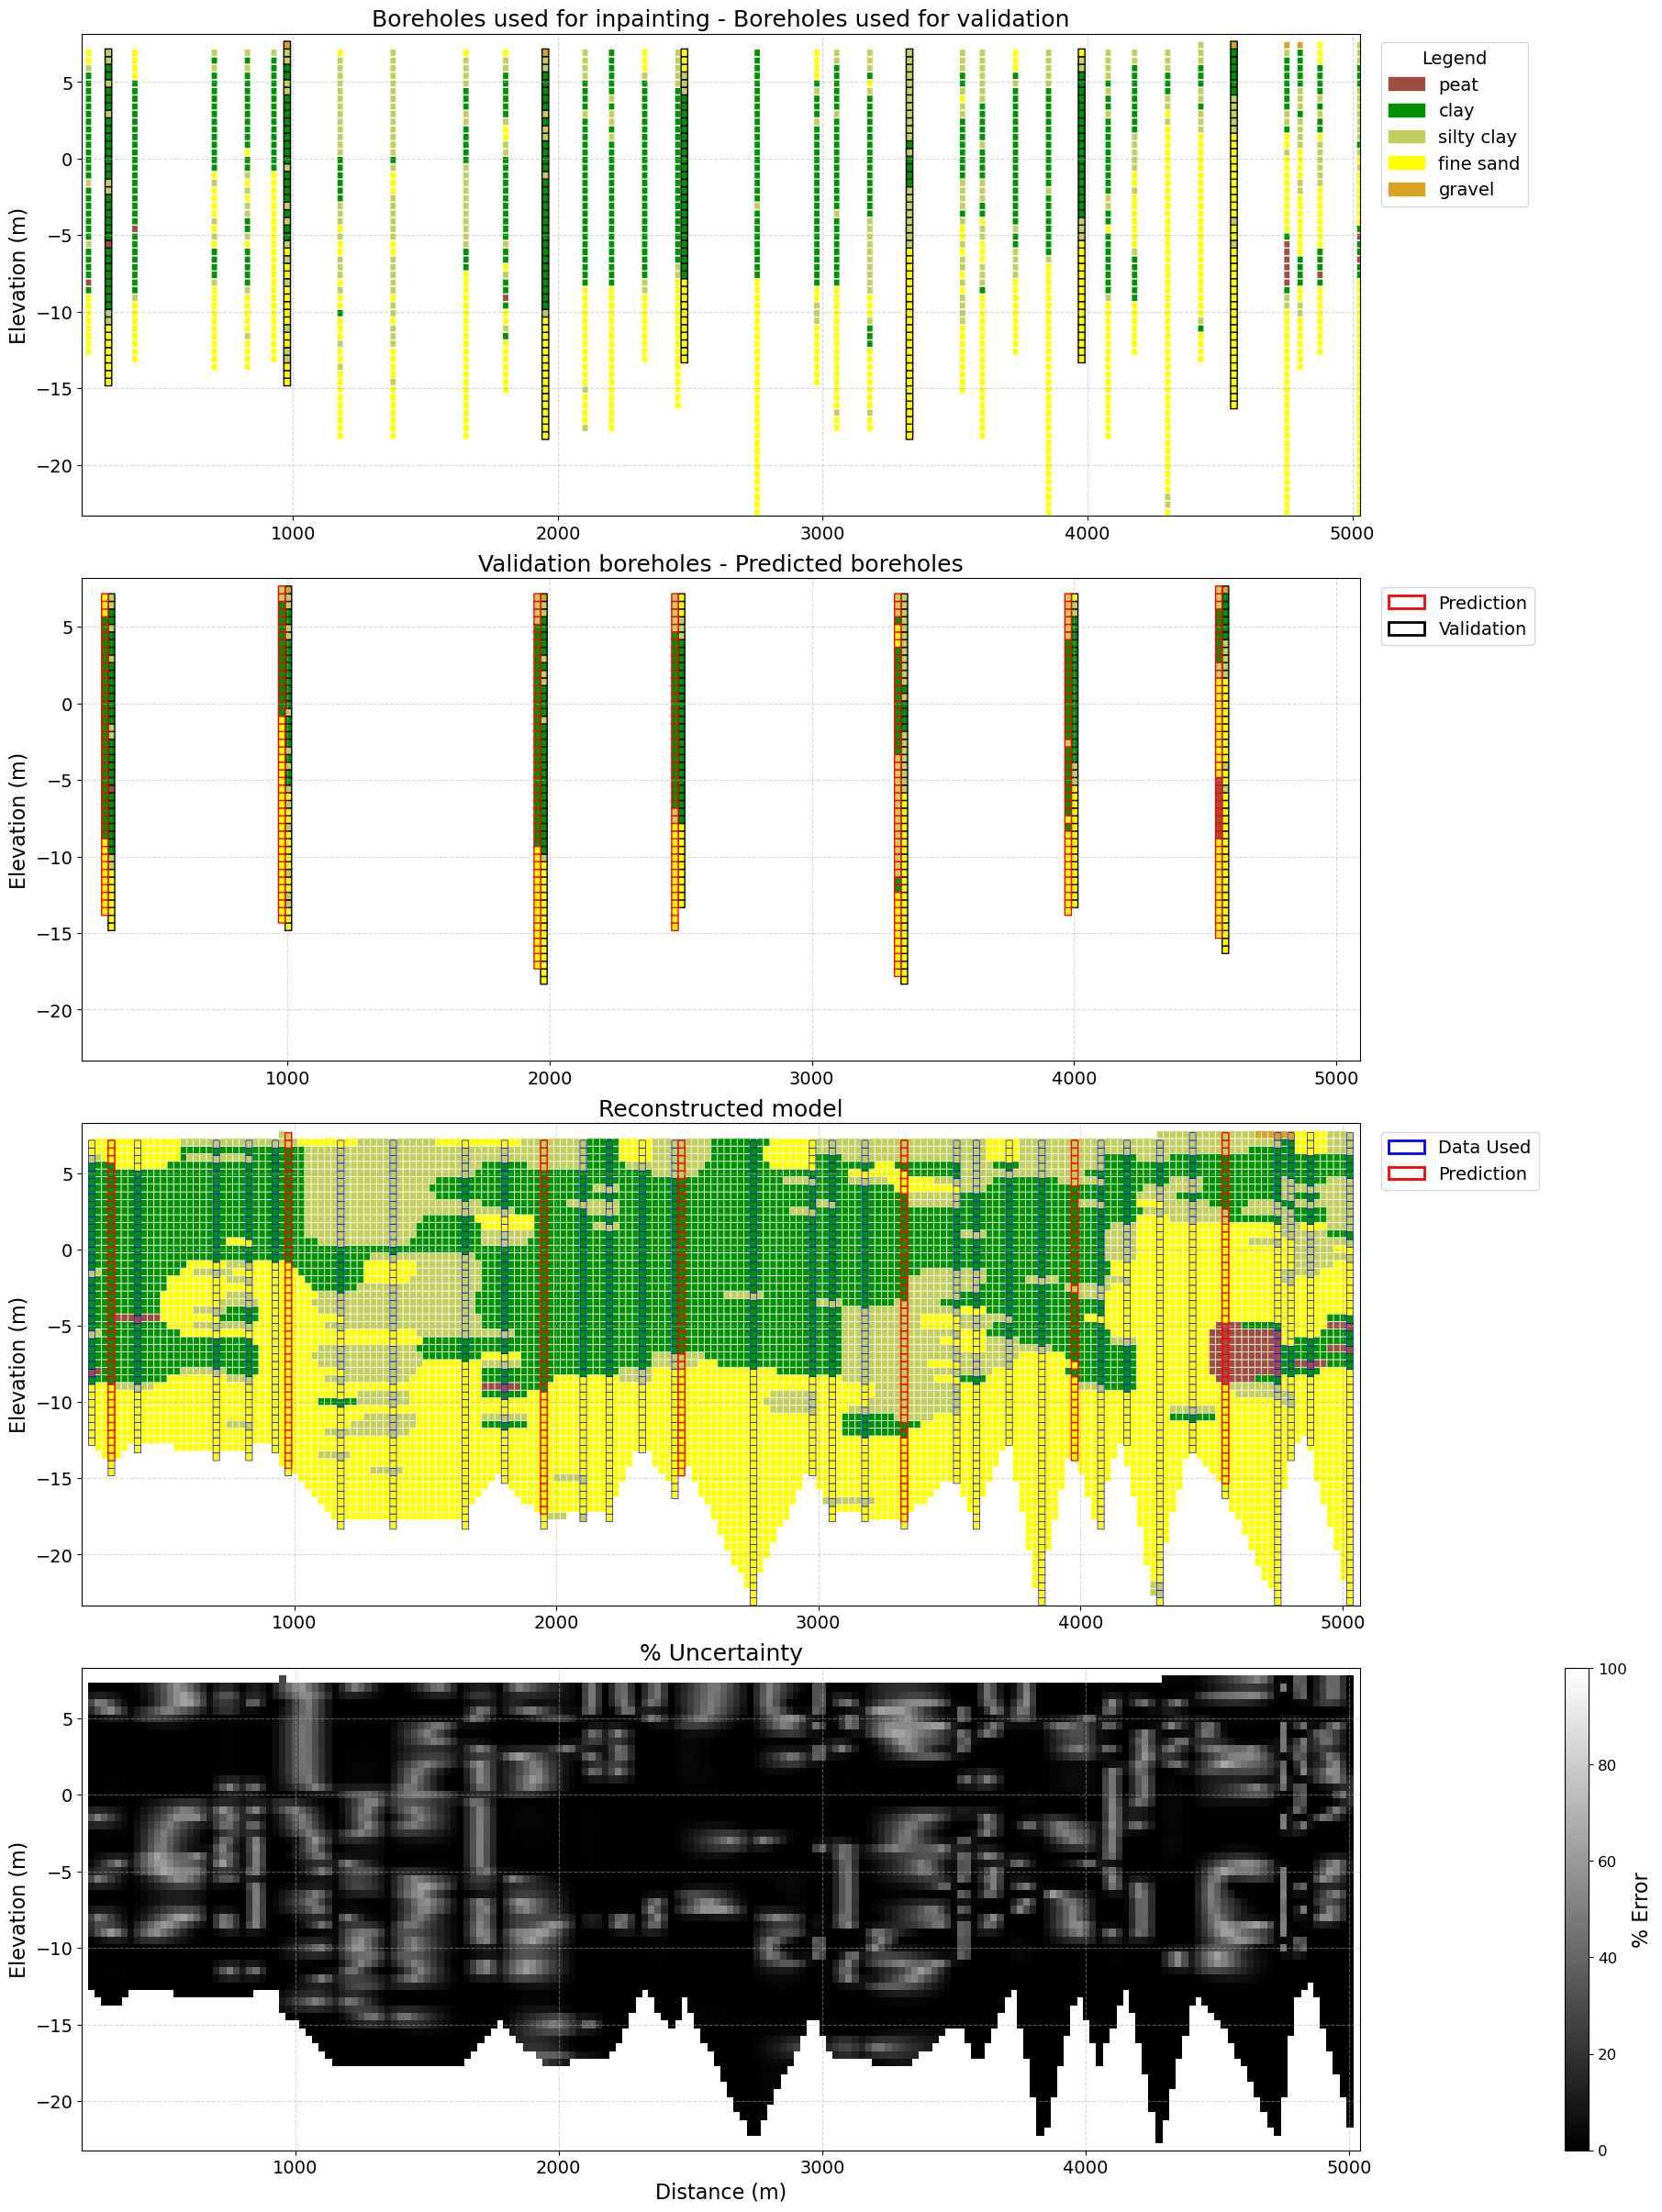

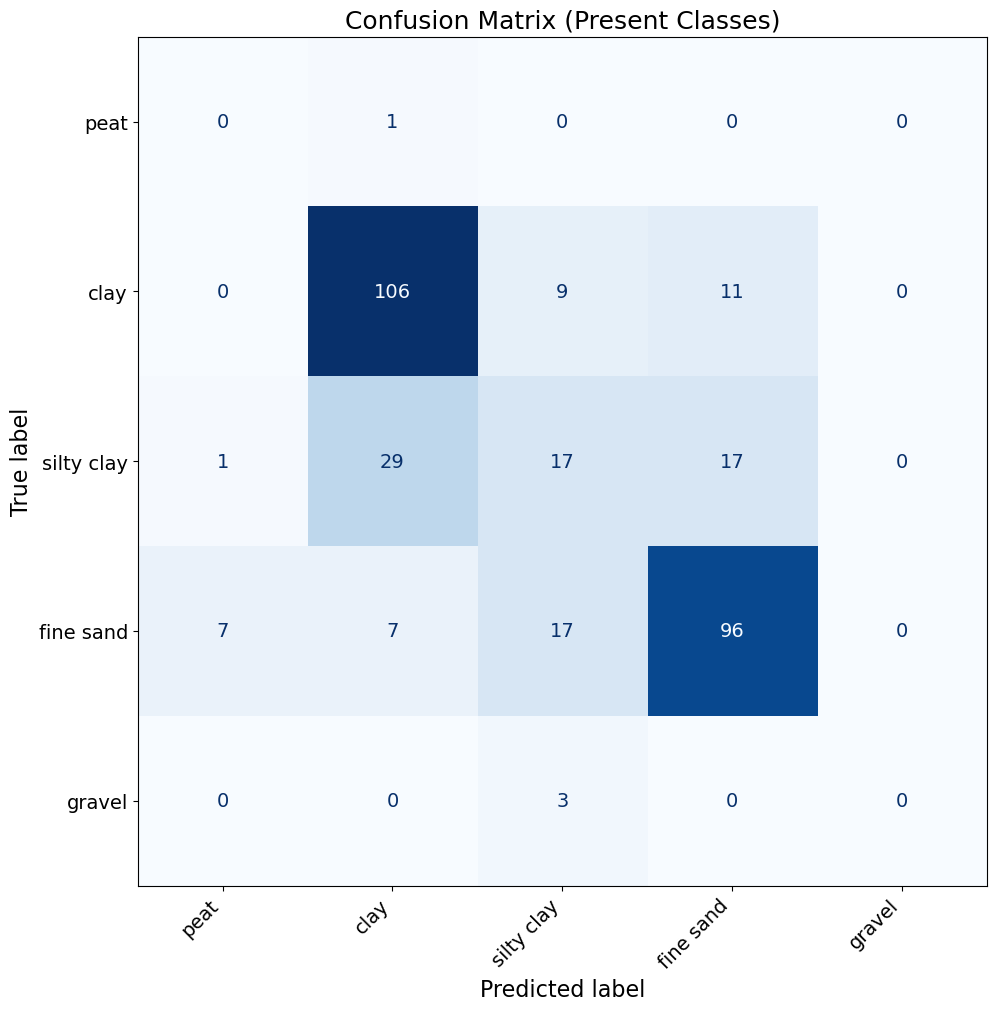

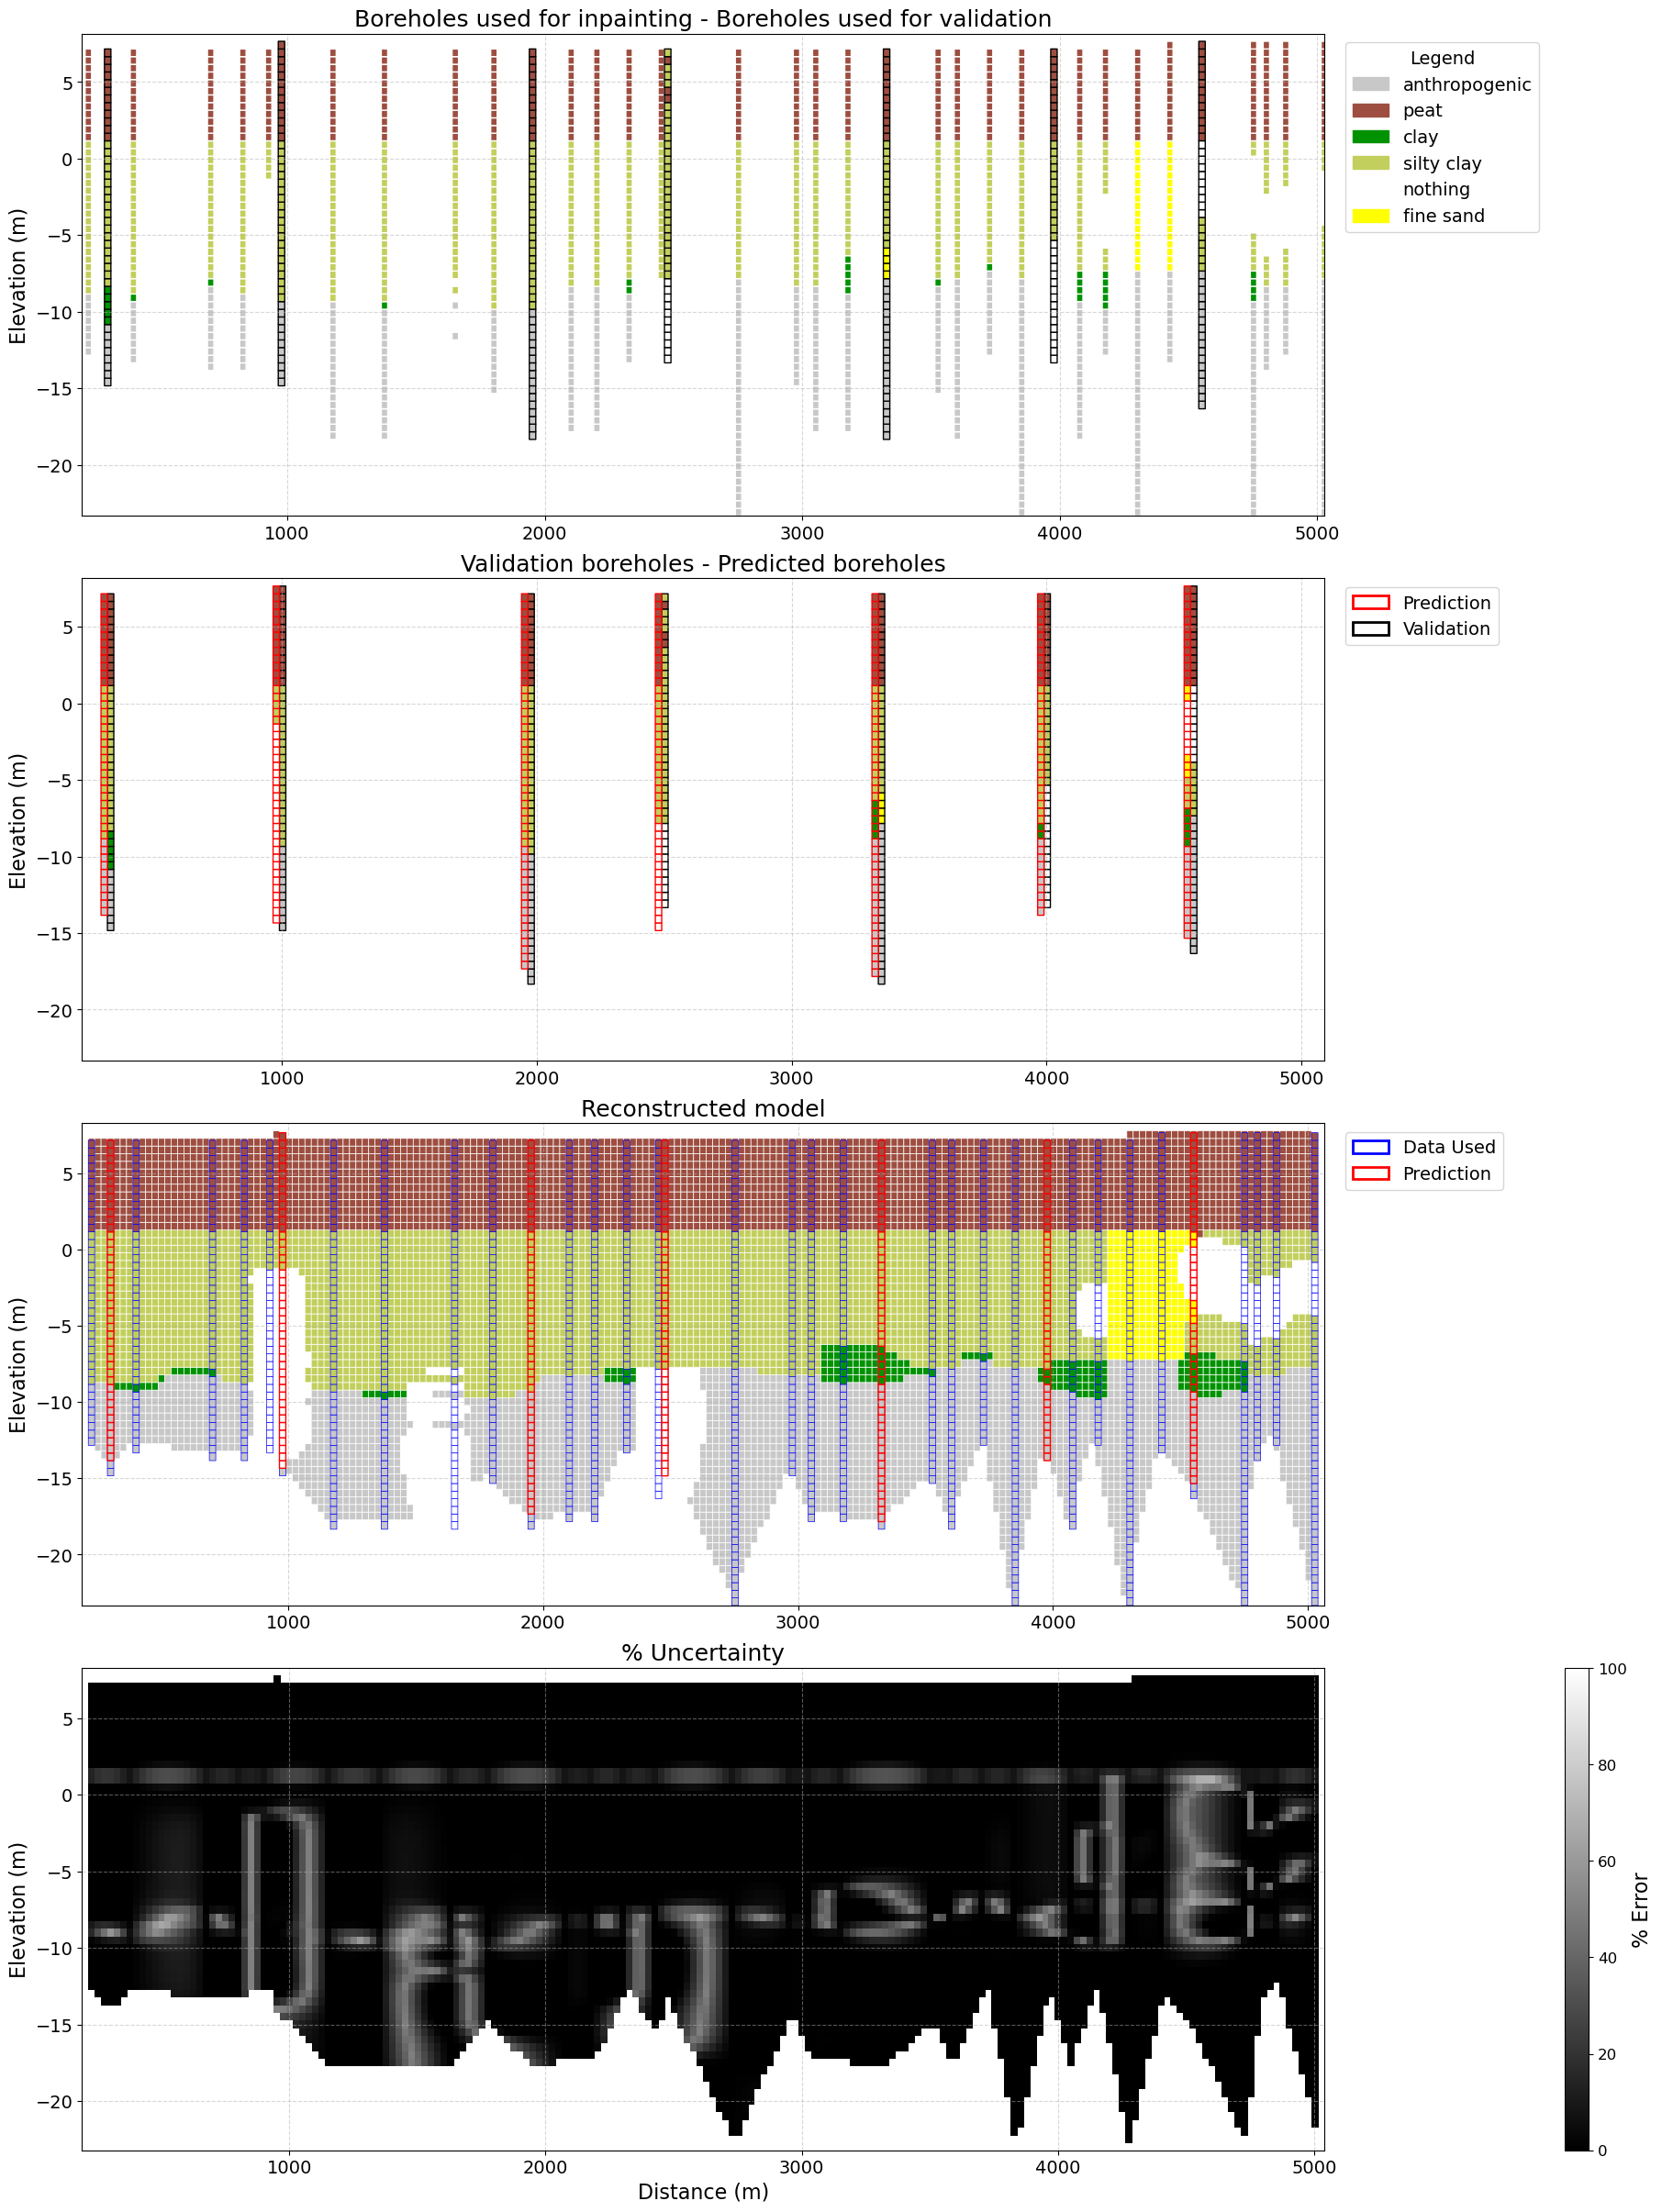

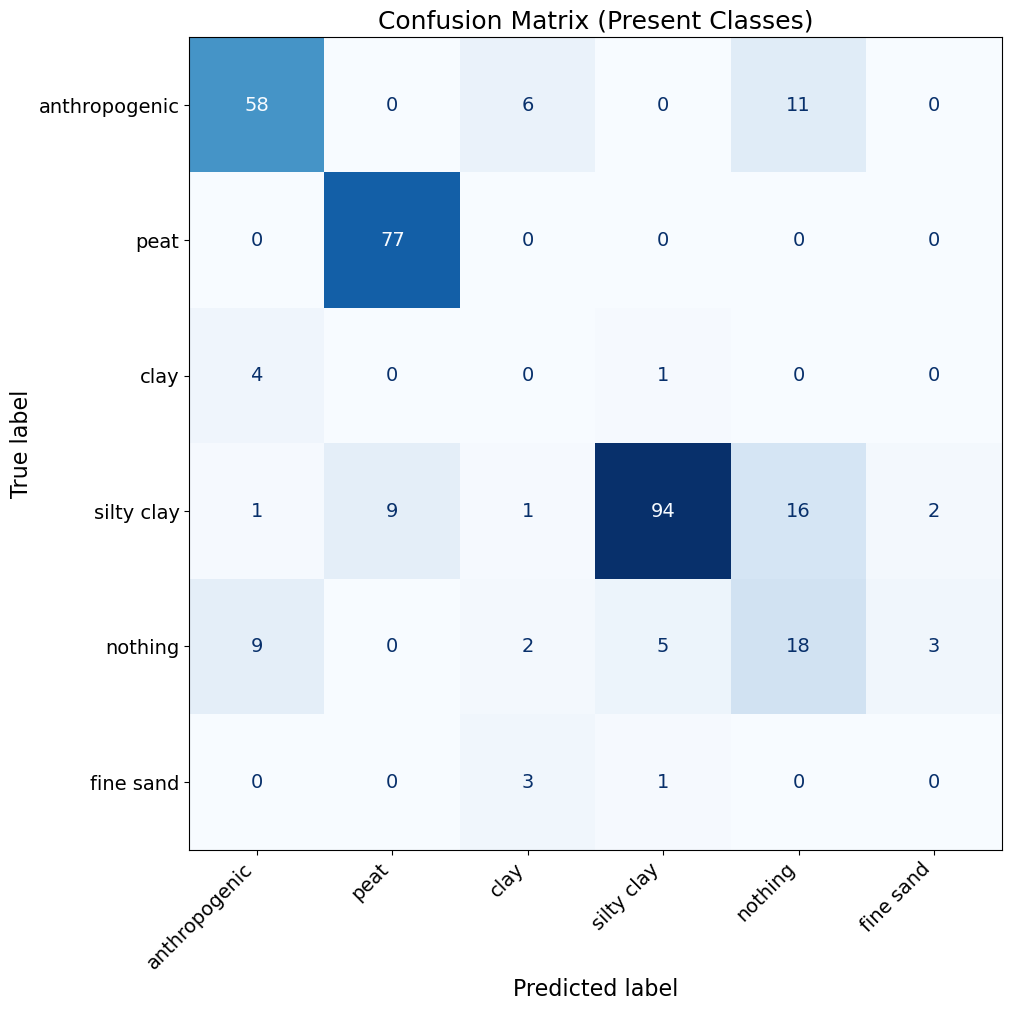

In [44]:

int3=Geo_Gridder([],[])
int3.one_vs_all(basis_inpaint, x_weight=1.0, y_weight=3.0)


plot_model_with_validation_real(
	int1.bs, basis_inpaint, int3.prediction_data, int1.xg, int1.yg, tt, int3.uncertainty_data,
	cmap=my_map, random_indices=random_indices, filename='model_with_validation_real1.pdf'
)
int3=Geo_Gridder([],[])
int3.one_vs_all(basis_inpaint2, x_weight=1.0, y_weight=3.0)


plot_model_with_validation_real(
	int2.bs, basis_inpaint2, int3.prediction_data, int2.xg, int2.yg, tt, int3.uncertainty_data,
	cmap=my_map, random_indices=random_indices, filename='model_with_validation_real1.pdf'
)





In [45]:
#plot_model_with_validation_real(basis_inpaint, del2, tt,del_perc, cmap=my_map, random_indices=random_indices,filename='model_with_validation_real1.pdf') 

#plot_model_with_validation_real(int2.bs, basis_inpaint2+1, del22, int2.xg,int2.yg,tt,del_perc, cmap='rainbow', random_indices=random_indices,filename='model_with_validation_real2.pdf') 


let's generate a 3D example and we are done

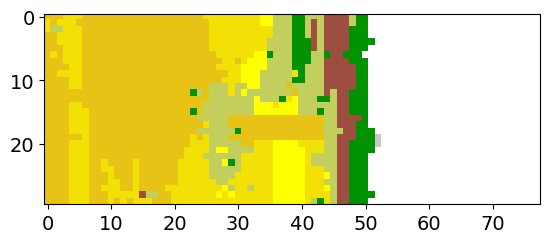

In [47]:
geotop = np.load('geotop.npy')


top = np.zeros((geotop.shape[0]*geotop.shape[1]))
n = 0
for i in range(0, geotop.shape[0]):
    for j in range(0, geotop.shape[1]):
        ix = np.where(np.isnan(geotop[i, j, :]))[0][0]
        top[n] = ix
        n += 1

geotop=geotop[:,:,:np.max(top).astype('int32')]    

geotop=geotop[20:50,30:60,50:]
# To visualize a single slice, e.g., the 20th slice:
i=20
plt.imshow(geotop[i,:,:], cmap=my_map, vmin=0, vmax=9)



#slicd it






So we have 50x80 boreholes we would like to play with

In [50]:
nx, ny = geotop.shape[0], geotop.shape[1]
total_points = nx * ny
n_select = int(0.95 * total_points)  # 20% of all points

# Generate all possible (row, col) index pairs
all_indices = np.array([(i, j) for i in range(nx) for j in range(ny)])

# Randomly select 20% of the indices without replacement
selected_indices = all_indices[np.random.choice(total_points, n_select, replace=False)]


# If you want to split into row and col arrays:
rows, cols = selected_indices[:, 0], selected_indices[:, 1]

# Find the indices that were NOT selected
not_selected_mask = np.ones(total_points, dtype=bool)
not_selected_mask[np.unique(np.ravel_multi_index(selected_indices.T, (nx, ny)))] = False
not_selected_indices = all_indices[~not_selected_mask]

# Split into row and col arrays for non-selected indices
not_rows, not_cols = not_selected_indices[:, 0], not_selected_indices[:, 1]

In [ ]:
#np.save('selected_indices_95', )
#np.save('not_selected_indices_95', not_selected_indices)





In [51]:
geoptop_inpaint = geotop.copy()
for r, c in zip(rows, cols):
    geoptop_inpaint[r, c, :] = np.nan

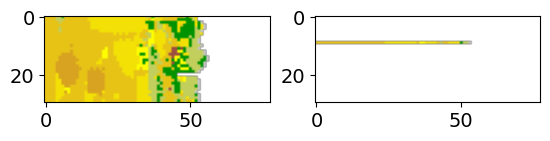

In [52]:
i=0
plt.subplot(1, 2, 1)
plt.imshow(geotop[i, :, :], cmap=my_map, vmin=0, vmax=9)
plt.subplot(1, 2, 2)
plt.imshow(geoptop_inpaint[i, :, :], cmap=my_map, vmin=0, vmax=9)


In [53]:
int1=VtkClass()
xc= np.arange(0, 100*geotop.shape[0],100)
yc= np.arange(0, 100*geotop.shape[1],100)
zc= np.arange(0, 0.5*geotop.shape[2]+0.5,0.5)





In [ ]:
#int1.make_3d_grid_to_vtk('geotop.vtk',np.transpose(geotop, (1, 0, 2)),xc,yc,zc)
#int1.make_3d_grid_to_vtk('geotop_to_inpaint_95.vtk',np.transpose(geoptop_inpaint, (1, 0, 2)),xc,yc,zc)

In [55]:
int1=Geo_Gridder([],[])
int1.one_vs_all_3d(geoptop_inpaint.copy(), x_weight=1, y_weight=1, z_weight=1)

In [ ]:
int1.prediction_data[np.isnan(geotop)]=np.nan
int1.uncertainty_data[np.isnan(geotop)]=np.nan

#Make plots in vtk
#int1.make_3d_grid_to_vtk('geotop_inpainted_95.vtk',np.transpose(del1, (1, 0, 2)),xc,yc,zc)
i#nt1.make_3d_grid_to_vtk('geotop_inpainted2_del_perc_95.vtk',np.transpose(del_perc, (1, 0, 2)),xc,yc,zc)

0

In [57]:
# Select all values from the 3rd dimension of geotop at (not_rows, not_cols)
true_label = geotop[not_rows, not_cols, :].ravel()
pred_label = int1.prediction_data[not_rows, not_cols, :].ravel()

mask = np.isfinite(true_label) & np.isfinite(pred_label)
true_label_finite = true_label[mask]
pred_label_finite = pred_label[mask]

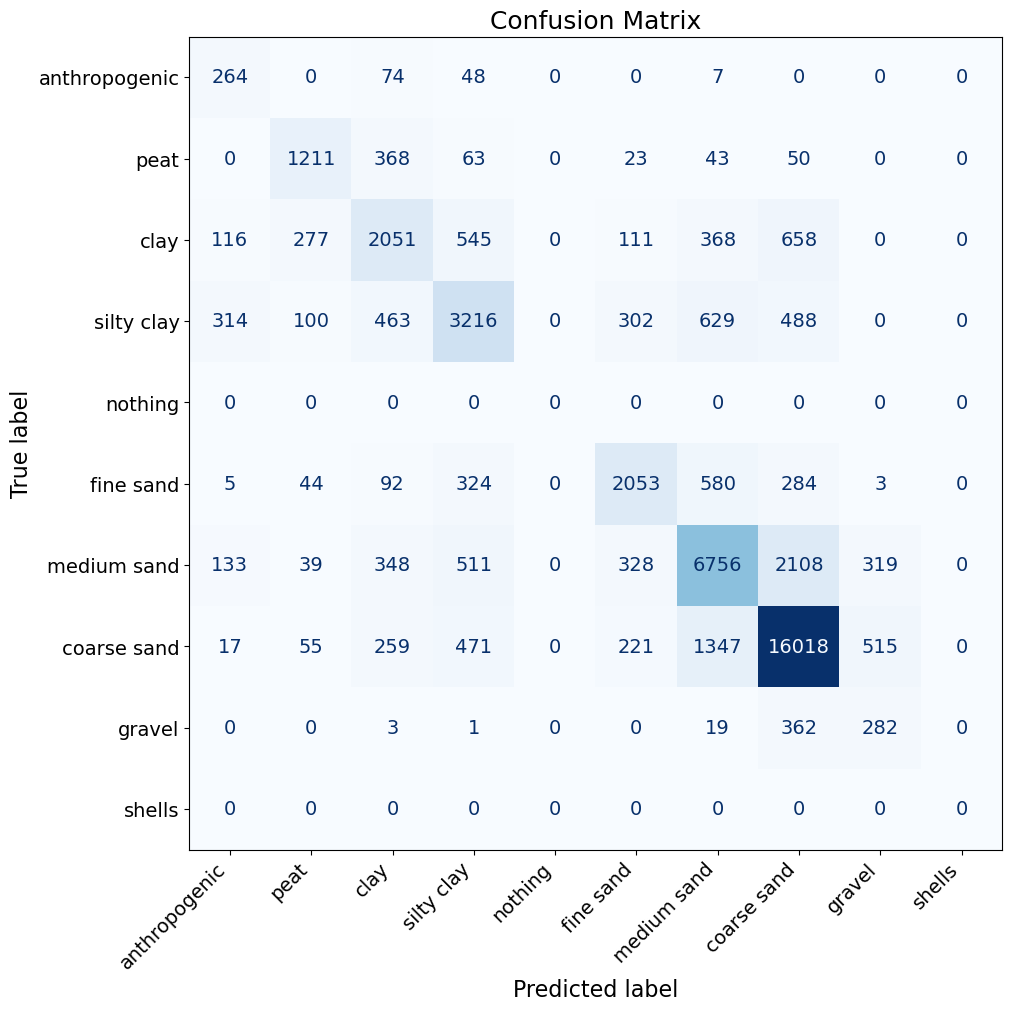

In [58]:
plot_confusion_matrix(true_label_finite, pred_label_finite, labels=labels, title='Confusion Matrix for 3D Inpainting', cmap=plt.cm.Blues)